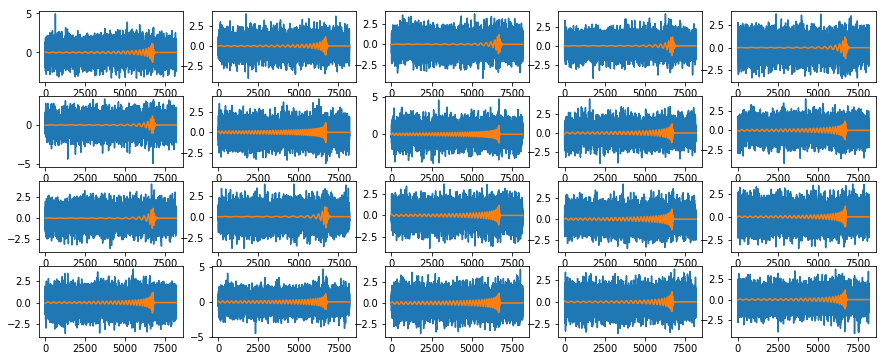

In [1]:
###
###  Prepare data: extract, transform, load (ETL)
###
import h5py as h5
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
    
import os
import time
from datetime import datetime

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

LABLE_WIDTH = 1
X_FEATURE = 'x'  # Name of the input feature.

RATE = 8192
BATCH = 128
EPOCHS = 300

#FLAGS = tf.app.flags.FLAGS
#tf.app.flags.DEFINE_string("train_data_path", "/home/yongcai/chinese_fenci/train.txt", "training data dir")
#tf.app.flags.DEFINE_string("log_dir", "./logs", " the log dir")
#tf.app.flags.DEFINE_integer("max_sentence_len", 80, "max num of tokens per query")
#tf.app.flags.DEFINE_integer("shuffle_buffer_size", )

class GWInject():
    def _add_noise(self, tag, A):
        var = self.f[tag]
        NX = len(var)
        X = (A * var[:NX,:] + np.random.normal(0,1,(NX,self.srate))).astype(np.float32)
        Y = np.ones(NX)
        NN = NX
        X  = np.vstack( (X, np.random.normal(0,1,(NN,self.srate)) )  ).astype(np.float32)
        Y  = np.hstack( (Y, np.zeros(NN) )                          ).astype(np.float32).reshape(-1,1)
        
        if 0:
            plt.figure(figsize=(16,5))
            for i in range(len(X)):
                plt.subplot(2,5,i+1)
                plt.plot(X[i,:])
                plt.plot(A * var[i,:])
                #plt.title(" )
                if (i > 8): break
            plt.show()

        return X, Y
    def __init__(self, fname):
        self.fname = fname
        self.f = h5.File(fname, "r")
        self.srate = self.f.attrs.get('srate')

    def __exit__(self):
        self.f.close()
        
    def get_train_val_set(self, A=1.0):
        X, Y = self._add_noise('/train', A)
        X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=None)
        return X_train, X_val, Y_train, Y_val
        
    def get_test_set(self, A=1.0):
        X, Y = self._add_noise('/test', A)
        return X,Y
    
    
tmp = GWInject("white_h_fixed.h5")
Xt, Xv, Yt, Yv = tmp.get_train_val_set(0.1)    
tmp.__exit__()

###  TODO: generate the training set on-the-fly with lamdba mapping  ??    
#ds = WaveDS("white_h_fixed.h5", A=1)
#ds.plot()

#train_ds = ds.train.batch(BATCH)
#test_ds  = ds.test.batch(BATCH)


/home/lincy/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
###
### Prepare NN model
###
def model_hi(x_, keep_prob, WIDTH):
    """
    Model that return logits
    """
    args = {"padding":'valid', "activation":None, 
        "kernel_initializer":tf.truncated_normal_initializer(), 
        "bias_initializer":tf.zeros_initializer()     }
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
    
    feature = tf.reshape(x_, [-1, WIDTH,1])
    c1 = convl(feature, F= 64, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    c2 = convl(c1,      F=128, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c3 = convl(c2,      F=256, K=16, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)
    c4 = convl(c3,      F=512, K=32, D=2, S=1, PO=4, PS=4, act=tf.nn.relu)

    dim = c4.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    l1 = tf.reshape(c4, [-1, fcnn])
    
    l2     = tf.layers.dense(l1, 128, activation=tf.nn.relu)
    l3     = tf.layers.dense(l2,  64, activation=tf.nn.relu)
    logits = tf.layers.dense(l3,   1, activation=None)
   
    return logits


def model(x_, keep_prob, WIDTH):
    feature = tf.reshape(x_, [-1, WIDTH,1])

    args = {"padding":'valid', "activation":None, 
            "kernel_initializer":tf.truncated_normal_initializer(), 
            "bias_initializer":tf.zeros_initializer()     }
    
    def convl(in_, F, K, D, S, PO, PS, act):
        out = tf.layers.conv1d( in_, filters=F, kernel_size=K, dilation_rate=D, strides=S, **args)
        out = tf.layers.max_pooling1d(out, pool_size=PO, strides=PS, padding='valid')
        return act(out)
        
    o1 = convl(feature, F=16, K=16, D=1, S=1, PO=4, PS=4, act=tf.nn.relu)
    o2 = convl(o1,      F=32, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    o3 = convl(o2,      F=64, K=8,  D=4, S=1, PO=4, PS=4, act=tf.nn.relu)
    
    dim = o3.get_shape().as_list()
    fcnn = dim[1]*dim[2]
    o4 = tf.reshape(o3, [-1, fcnn])
    # Densely connected layer
    o4     = tf.layers.dense(o4, 64, activation=tf.nn.relu)
    logits = tf.layers.dense(o4, 1, activation=None)
    
    return logits


In [3]:
###
###  Construct TF graph
###
tf.reset_default_graph()
DIM = 8192
keep_prob = tf.placeholder(tf.float32)  ##  for dropout
bs        = tf.placeholder(tf.int64)    ##  for initalizer

x = tf.placeholder(tf.float32, [None,DIM])
y = tf.placeholder(tf.float32, [None,1])

train_ds = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=10000).batch(bs).repeat()
test_ds  = tf.data.Dataset.from_tensor_slices((x, y)).shuffle(buffer_size=10000).batch(bs)

## Use two iterators
#train_iter = train_ds.make_initializable_iterator()  ## 
#test_iter  = test_ds.make_initializable_iterator()   ## no shuffle/repeat

## Use one common iterator
iter = tf.data.Iterator.from_structure(train_ds.output_types, train_ds.output_shapes)
features, labels = iter.get_next()

# create the initialisation operations
train_init_op = iter.make_initializer(train_ds)
test_init_op = iter.make_initializer(test_ds)

#logits = model(features, keep_prob, DIM)
logits = model_hi(features, keep_prob, DIM)

# Compute predictions
with tf.name_scope('eval'):
    predict_prob = tf.sigmoid(logits, name="sigmoid_tensor")
    predict_op   = tf.cast( tf.round(predict_prob), tf.int32 )
with tf.name_scope('loss'):
    ## with reduction compared to tf.nn.softmax_cross_entropy_with_logits_v2 
    loss_op = tf.losses.sigmoid_cross_entropy(logits=logits, multi_class_labels=labels)
with tf.name_scope('adam_optimizer'):
    optimizer = tf.train.AdamOptimizer(1e-4).minimize(loss_op)

#correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
#correct_prediction = tf.cast(correct_prediction, tf.float32)
#accuracy = tf.reduce_mean(correct_prediction)
_, accuracy    = tf.metrics.accuracy(labels=labels, predictions=predict_op  )
_, sensitivity = tf.metrics.recall(labels=labels, predictions=predict_op  )

_, fp = tf.metrics.false_positives(labels=labels, predictions=predict_op  )
_, fn = tf.metrics.false_negatives(labels=labels, predictions=predict_op  )
_, tp = tf.metrics.true_positives(labels=labels, predictions=predict_op  )
_, tn = tf.metrics.true_negatives(labels=labels, predictions=predict_op  )

graph_location = '/tmp/tf_tmp'
merged = tf.summary.merge_all()
print('Saving graph to: %s' % graph_location)

### check all variables
if 1:
    vars = 0
    for v in tf.global_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Whole size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.global_variables()) ) )

    vars = 0
    for v in tf.trainable_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: %.3f MB | Var # : %d" % (8*vars/(1024**2), len(tf.trainable_variables()) ) )

    vars = 0
    for v in tf.local_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Local var size: %.3f Bytes | Var # : %d" % (8*vars, len(tf.local_variables()) ) )

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Saving graph to: /tmp/tf_tmp
<tf.Variable 'conv1d/kernel:0' shape=(16, 1, 64) dtype=float32_ref>
<tf.Variable 'conv1d/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'conv1d_1/kernel:0' shape=(16, 64, 128) dtype=float32_ref>
<tf.Variable 'conv1d_1/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'conv1d_2/kernel:0' shape=(16, 128, 256) dtype=float32_ref>
<tf.Variable 'conv1d_2/bias:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'conv1d_3/kernel:0' shape=(32, 256, 512) dtype=float32_ref>
<tf.Variable 'conv1d_3/bias:0' shape=(512,) dtype=float32_ref>
<tf.Variable 'dense/kernel:0' shape=(7168, 128) dtype=float32_ref>
<tf.Variable 'dense/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'dense_1/kernel:0' shape=(128, 64) dtype=float32_ref>
<tf.Variable 'dense_1/bias:0' shape=(64,) dtype=float32_ref>
<tf.Variable 'dense_2/kernel:0' shape=(64, 1) dtype=float32_ref>
<tf.Variable 'dense_2/bias:0' sha

(7740, 8192)
(7740, 1)
Trainning for A= 1.000000
   step:     0, loss: 424710.062 accuracy:  0.422 sec:      1 speed:   537.5 /sec
   step:   200, loss:   1164.669 accuracy:  0.664 sec:  0.967 speed:   847.9 /sec
   step:   400, loss:    392.700 accuracy:  0.763 sec:  0.954 speed:   843.9 /sec
   step:   600, loss:    481.797 accuracy:  0.807 sec:  0.937 speed:   825.6 /sec
   step:   800, loss:      0.000 accuracy:  0.845 sec:  0.949 speed:   846.8 /sec
Test for A= 1.00 : loss:   694.536 Acc:     0.947, Sen:     0.907, TP/TN/FP/FN:   487   483     4    50 
Test for A= 0.95 : loss:  1078.846 Acc:     0.929, Sen:     0.884, TP/TN/FP/FN:   451   500    14    59 
Test for A= 0.90 : loss:  1800.837 Acc:     0.898, Sen:     0.810, TP/TN/FP/FN:   413   507     7    97 
Test for A= 0.80 : loss:  3612.993 Acc:     0.818, Sen:     0.653, TP/TN/FP/FN:   338   500     6   180 
Test for A= 0.70 : loss:  7609.881 Acc:     0.727, Sen:     0.476, TP/TN/FP/FN:   250   494     5   275 
Test for A= 0.60

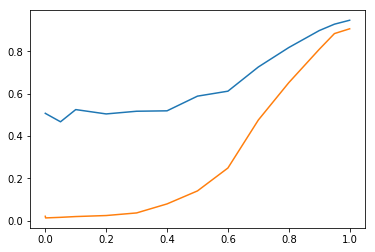

In [5]:
##
##  Use Numpy matrix
##
STEPS=10000
if 0:
    for i in range(10):
        feature, label = iter.get_next()
        print (feature.shape, label.shape)
       
GWdata = GWInject("white_h_fixed.h5")
Xt, Xv, Yt, Yv = GWdata.get_train_val_set()
print (Xt.shape)
print (Yt.shape)
Xts, Yts       = GWdata.get_test_set()
#print("Test set size: %.3f MBytes" % (np.prod(np.shape(Xts))*4/1024**2 ) )

with tf.Session() as sess:
    
    #train_writer = tf.summary.FileWriter(graph_location + '/train', sess.graph)
    #train_writer.add_graph(tf.get_default_graph())
    #test_writer  = tf.summary.FileWriter(graph_location + '/test')

    sess.run(tf.global_variables_initializer())

    MONITOR=200
    ##for amplitude in [1.2, 1.0, 0.8, 0.6, 0.5, 0.4, 0.3, 0.2]:
    for amplitude in [1.0]:
        sess.run(tf.local_variables_initializer())

        print("Trainning for A= %f"% amplitude)
        Xt, Xv, Yt, Yv = GWdata.get_train_val_set(A=amplitude)
        sess.run(train_init_op, feed_dict={ x:Xt, y:Yt, bs:BATCH})   ##, batch_size: BATCH

        for i in range(STEPS):
            optimizer.run()
            time0 = time.time()
            if i % MONITOR == 0:
                _, loss, acc, sen = sess.run( [optimizer, loss_op, accuracy, sensitivity] )   ## 
           
                time1 = time.time()
                duration = time1 - time0
                speed = MONITOR / duration
                time0 = time1
                print('   step: %5d, loss: %10.3f accuracy: %6.3g sec: %6.3g speed: %7.1f /sec' % (i, loss, acc, sen, speed))
                if loss < 1e-10:
                    break
            

    ### Testing
    TEST_LIST = [1.0, 0.95, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.001, 0.0]
    gacc=[]
    gsen=[]
    for amplitude in TEST_LIST:
        sess.run(tf.local_variables_initializer())

        Xts, Yts       = GWdata.get_test_set(A=amplitude)
        sess.run(test_init_op, feed_dict={ x: Xts, y: Yts, bs:1024 })

        pre, loss, acc, sen, ttp, ttn, tfp, tfn = sess.run([predict_prob, loss_op, accuracy, sensitivity, tp, tn, fp, fn ])
        gsen.append(sen)
        gacc.append(acc)
        print("Test for A= %4.2f : loss: %9.3f Acc: %9.3f, Sen: %9.3f, TP/TN/FP/FN: %5d %5d %5d %5d " 
              % (amplitude, loss, acc, sen, ttp, ttn, tfp, tfn) )
    
    plt.figure()
    plt.plot(TEST_LIST, gacc)
    plt.plot(TEST_LIST, gsen)
    plt.show()

In [ ]:
a=[.0160.917]